## Obtaining distributions

This notebook solves for the stationary distribution of the income fluctuation problem using (i) discretization of the
density function (histogram/Young's 2010 method), (ii) the eigenvector method, and (iii) using Monte Carlo simulation

In [2]:
using NBInclude

@nbinclude("EGM.ipynb") # include EGM functions (make sure it is in your working directory)
                        # also reloads household tuple, but this won't affect anything

policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
policy function iteration successful!
  666.264 ms (73236 allocations: 365.32 MiB)


([0.07096749424518328 0.09474585074712497 … 0.32374756274362093 0.44736616230505283; 0.0802685772211671 0.10402894671986812 … 0.33296332057926986 0.456566049492291; … ; 4.469192997723292 4.494141840127407 … 4.731285018197259 4.858247293339893; 4.478015411449168 4.502964924185298 … 4.740113894500879 4.867079161438543], [0.15810405476459372 0.25061327583238513 … 1.4605614789125752 2.2427427352778837; 0.589684735315664 0.6822119433866962 … 1.8922274846039804 2.6744246116176993; … ; 215.31899678775943 215.41033552292507 … 216.6121422599319 217.390979840716; 215.75105613756062 215.84239420239425 … 217.04419514715536 217.82302973614443])

Define household tuple.

In [3]:
using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools

Household = @with_kw (apoints = 500, #asset grid
    amax = 200,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2]) # income grid


function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

hh = Household()

(apoints = 500, amax = 200, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.40080160320641284 0.40080160320641284 … 0.40080160320641284 0.40080160320641284; … ; 199.59919839679358 199.59919839679358 … 199.59919839679358 199.59919839679358; 200.0 200.0 … 200.0 200.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.0225942669471

In [4]:
c, policyfun = iterate_egm(hh, r = 0.01) # making sure everything works

policy function iteration successful!


([0.229071549009777 0.34535912657951007 … 1.3943103412622557 1.7725763501505858; 0.29940986080153575 0.41575409569487365 … 1.4104899162084368 1.7853963993344497; … ; 5.2059736356104285 5.298502192433754 … 5.959082533344494 6.252787120087693; 5.214368528291747 5.306894732806059 … 5.967454243451358 6.261149639196992], [0.0 0.0 … 0.38999870039394025 0.9175325474323506; 0.33447130744671816 0.33441465012311344 … 0.7786287446862361 1.3095221174869638; … ; 196.61828829416086 196.6420473149073 … 197.42041688907324 198.03251215825676; 197.01470302071803 197.03846439377347 … 197.81685479820484 198.42895925838596])

This function provides us with a transition kernel over asset-income space using Young's (2010) lottery method. The main difficulty arises because the policy function does not map ONTO the grids we have defined. We need to take care of this if we wish to obtain a transition kernel.

In [5]:
function get_kernel(hh; policyfun)
    
"""
    get transition kernel for asset-income distribution using Young's method
    
    #### Fields
    
    - 'hh': household tuple
    - 'policyfun': savings function, array na x ny
    
    #### Returns
    
    - 'kernel': na*ny x na*ny array row-stochastic transition kernel
                first na rows correspond to income state 1, second na rows to income state 2, etc...
    
"""

    @unpack apoints, Amat, num_states, Ymat, transition_matrix = hh

    # construct transition matrix without labour stochasticity
    Q = zeros(apoints, apoints, num_states)

    # find which element to interpolate to
    findnearest(A,t) = findmin(abs.(A.-t))[2]

    # construct matrices to get neighboring indices
    next = similar(Amat)
    previous = similar(Amat)

    for j = 1:num_states
        for k = 1:apoints
            ind = findnearest(Amat[:,j],policyfun[k,j])
                if policyfun[k,j] - Amat[ind,j] > 0
                    previous[k,j] = Amat[ind,j]
                    if ind == apoints
                        next[k,j] = Amat[ind,j]
                    else         
                    next[k,j] = Amat[ind+1,j]
                    end
                elseif policyfun[k,j] == Amat[ind,j]
                    previous[k,j] = policyfun[k,j] 
                    next[k,j] = policyfun[k,]
                else
                    next[k,j] = Amat[ind,j]
                    if ind == 1
                        previous[k,j] = Amat[ind,j]
                    else
                        previous[k,j] = Amat[ind-1,j]
                    end
                end  
        end
    end

    # construct transition matrix for assets.
    # Q[i,j,k] is the probability of going to agrid[i] when current assets are agrid[j] and income is ygrid[k]
    for k = 1:apoints
        for j = 1:num_states
            if next[k,j] == previous[k,j]
                Q[Amat[:,1].==previous[k,j],k,j] .= 1
            else
                Q[Amat[:,1].==previous[k,j],k,j] .= (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])
                Q[Amat[:,1].==next[k,j],k,j] .= 1 - (next[k,j]-policyfun[k,j])./(next[k,j]-previous[k,j])

            end
        end
    end

    # construct transition kernel by taking the kronecker product of assets and transition_matrix for income
    kernel = zeros(apoints*num_states,apoints*num_states)

    for j=1:num_states
        for i=1:num_states
            kernel[(i-1)*apoints+1:i*apoints,(j-1)*apoints+1:j*apoints]=Q[:,:,j].*transition_matrix[j,i];
        end
    end

    kernel = kernel'

    return kernel
end

get_kernel (generic function with 1 method)

In [6]:
kernel = get_kernel(hh; policyfun = policyfun)

3500×3500 Adjoint{Float64,Array{Float64,2}}:
 0.902238  0.0       0.0       0.0       …  0.0      0.0        0.0  0.0  0.0
 0.149315  0.752923  0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.243929  0.658309  0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.318117  0.584121     0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.381078     0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0      0.0        0.0  0.0  0.0
 0.0       0.0       0.0       0.0          0.0      0.0        0.0  0.0  0.0
 0.0       0.0     

In [7]:
# histogram method

function histogram_method(; kernel, tol=1e-8, maxiter=1000)
    #initial guess for invariant distribution
    init = ones(size(kernel)[1])
    init = init./sum(init)
    
    for i=1:maxiter
        initnext = (init'*kernel)'
        if norm(init-initnext,Inf) < tol 
            println("distribution iteration successful!")
            return initnext
        else
            init = initnext
        end
    end
    
    error("distribution did not convergence!")
end

histogram_method (generic function with 1 method)

We need to perturb the matrix before using the eigenvector matrix because it is very large and sparse. This makes it less likely that there will be negative elements when we use routines to obtain the eigenvector.

In [8]:
# eigenvector method - requires SciPy for efficiency but can also be implemented in pure Julia

using SciPy

function eigenvector_method(; kernel, perturb = 1e-15)
    # perturb and normalize sparse matrix
    kernel = kernel .+ perturb
    kernel = kernel./sum(kernel, dims=2)
    
    _, stat = sparse.linalg.eigs(kernel',k=1)
    
    stat = Real.(stat)
    stat = stat./sum(stat)
    
    @assert sum(stat .< 0) == 0 "negative elements in distribution!"
    
    return stat
end

eigenvector_method (generic function with 1 method)

Both routines are reasonably quick -- around 2-3 seconds (note: run the code twice when using @time because the first time incorporates compilation time).

In [43]:
@time s1 = histogram_method(kernel = kernel)
@time s2 = eigenvector_method(kernel = kernel)

norm(s1-s2,Inf) # very similar distributions

distribution iteration successful!
  4.405854 seconds (2.11 k allocations: 27.936 MiB)
  2.772195 seconds (119 allocations: 187.064 MiB, 9.44% gc time)


2.6978856618176117e-7

The function below uses the Monte-Carlo simulation method. I have found that you need to increase I to eliminate randomness and dependence on initial conditions. At the current scale, this is already around 6x slower than the other methods.

In [10]:
using QuantEcon # has efficient simulation routines for discrete markov chains

function montecarlosim(hh; policyfun, I = 10000, T = 10000, tol=1e-3)
    @unpack transition_matrix, ygrid, Amat = hh

    mc = MarkovChain(transition_matrix, ygrid) # use QuantEcon simulation routines

    assets = zeros(I,T) # grid that will hold assets
    assets[:,1] .= 1 # representative agent capital holdings

    income_realizations = similar(assets)

    for i = 1:I
       income_realizations[i,:] = simulate_indices(mc, T) 
    end

    interp_array = [] # we need to interpolate the policy function because it does not map onto Amat

    # create interpolation objects - one for each income state
    for income in eachindex(ygrid)
        push!(interp_array, LinearInterpolation(Amat[:,1], policyfun[:,income])) 
    end

    # we pass on the simulation results onto the policy function
    @time for j = 2:T
        for i = 1:I
            assets[i,j] = interp_array[Int(income_realizations[i,j])](assets[i,j-1])
        end
    end

    assets = assets./I

    res1 = sum(assets[:,T])
    res2 = sum(assets[:,T-1])

    @assert abs(res1-res2) < tol "not ergodic yet, try increasing T or I"
    
    distribution = assets[:,T]
    aggregate_capital = sum(assets[:,T])

    return distribution, aggregate_capital
end


montecarlosim (generic function with 1 method)

In [13]:
s3, K3 = montecarlosim(hh, policyfun = policyfun) # you need to increase I and T to obtain better results, there is still
                                              # dependence on initial parameters, so you might get an assertion error

 30.283551 seconds (199.98 M allocations: 2.980 GiB, 2.46% gc time)


([2.0419234105525413e-7, 5.053169019892605e-6, 6.69954703635878e-7, 0.00016955872204375543, 3.2072095169555935e-6, 7.752358143977185e-6, 0.00010499828096097894, 0.00033649264138913313, 5.583148053301282e-8, 0.00020192307869545677  …  6.962072060465123e-5, 6.042772521938362e-6, 7.890296677172701e-6, 8.080272583417138e-5, 0.0001413671214162384, 4.234129358219308e-6, 4.163461515385459e-8, 0.0009078991343511586, 0.00013442407705802325, 7.03247673698599e-5], 2.353172708987424)

In [15]:
# check aggregate capital in all three distributions

K1 = getcapital(policyfun = policyfun, dist = s1)
K2 = getcapital(policyfun = policyfun, dist = s2)

@show K1
@show K2
@show K3

K1 = 2.319969384062138
K2 = 2.3199627340651907
K3 = 2.353172708987424


2.353172708987424

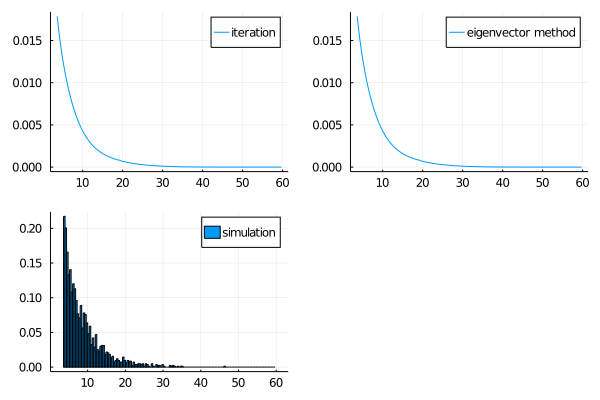

In [61]:
function plot_distributions(hh; iterate = s1, eigenvector = s2, simulation = s3)
    
    @unpack Amat = hh

    iterate = reshape(iterate,(500,7))
    iterate = sum(iterate, dims=2)
    
    eigenvector = reshape(eigenvector,(500,7))
    eigenvector = sum(eigenvector, dims=2)

    p1 = plot(Amat[10:150,1], iterate[10:150], label = "iteration")
    p2 = plot(Amat[10:150], eigenvector[10:150], label = "eigenvector method")
    p3 = histogram(simulation*10000, bins = Amat[10:150,1], label = "simulation", normed = true)
    
    plot(p1,p2,p3, layout = 3)
    
end

plot_distributions(hh)

